In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

In [2]:
housing = pd.read_csv("/kaggle/input/clean-dataset-house-pricing/clean_data.csv")
df=housing
learning_rate = 1e-3
n_iters = 10000

In [3]:
print(housing)

        price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0    13300000  7420         4          2        3      yes        no       no   
1    12250000  8960         4          4        4      yes        no       no   
2    12250000  9960         3          2        2      yes        no      yes   
3    12215000  7500         4          2        2      yes        no      yes   
4    11410000  7420         4          1        2      yes       yes      yes   
..        ...   ...       ...        ...      ...      ...       ...      ...   
540   1820000  3000         2          1        1      yes        no      yes   
541   1767150  2400         3          1        1       no        no       no   
542   1750000  3620         2          1        1      yes        no       no   
543   1750000  2910         3          1        1       no        no       no   
544   1750000  3850         3          1        2      yes        no       no   

    hotwaterheating aircond

In [4]:
target_col = df.columns[0]

# Xác định các cột liên tục (numeric) và phân loại (object)
continuous_cols = df.select_dtypes(include=['float64', 'int64']).columns.drop(target_col, errors='ignore')
categorical_cols = df.select_dtypes(include=['object']).columns

# Chuẩn hóa các cột liên tục
# scaler = StandardScaler()
scaler = MinMaxScaler()
df[continuous_cols] = scaler.fit_transform(df[continuous_cols])

# Label encode các cột phân loại
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

In [5]:
# Chia dữ liệu
X_train, X_test, y_train, y_test = train_test_split(
    df.iloc[:, 1:], df.iloc[:, 0], test_size=0.2, random_state=42
)

# Linear Regression

In [6]:
class LinearRegression:
    def __init__(self, learning_rate=0.001, n_iters=1000):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iters):
            y_predicted = np.dot(X, self.weights) + self.bias

            # Tính đạo hàm
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)

            # Cập nhật trọng số
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        return mse, mae, r2

In [7]:
# Huấn luyện mô hình
reg = LinearRegression(learning_rate=learning_rate, n_iters=10000)
reg.fit(X_train, y_train)

# Dự đoán trên dữ liệu test
predictions = reg.predict(X_test)

# Tính các thông số đánh giá
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Hiển thị các thông số đánh giá
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'R-squared: {r2:.2f}')

Mean Squared Error (MSE): 2048385386436.48
Mean Absolute Error (MAE): 1015852.35
R-squared: 0.59


# ANN

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

# Chuyển dữ liệu thành tensor
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Xây dựng mô hình ANN
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

class ANN_Model(nn.Module):
    def __init__(self, input_size, output_size):
        super(ANN_Model, self).__init__()
        self.hidden_layer_1 = nn.Linear(input_size, 64)
        self.hidden_layer_2 = nn.Linear(64,32)
        self.hidden_layer_3 = nn.Linear(32,16)
        self.output_layer = nn.Linear(16, output_size)
        
    def forward(self, x):
        x = torch.relu(self.hidden_layer_1(x))
        x = torch.relu(self.hidden_layer_2(x))
        x = torch.relu(self.hidden_layer_3(x))
        x = self.output_layer(x)
        return x

    def predict(self, x):
        x = torch.tensor(x.values, dtype=torch.float32)  # Đảm bảo x là tensor
        output = self.forward(x)  
        return output.detach().numpy().flatten()  # Sử dụng .flatten() để chuyển thành mảng 1 chiều

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        return mse, mae, r2

In [9]:
# Khởi tạo mô hình ANN
input_size = X_train.shape[1]  # Số lượng đặc trưng
output_size = 1  # Vì đây là bài toán hồi quy

ann_model = ANN_Model(input_size, output_size)

# Định nghĩa loss function và optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(ann_model.parameters(), lr=0.001)

# Huấn luyện mô hình
n_epochs = 10000
for epoch in range(n_epochs):
    ann_model.train()
    
    # Dự đoán và tính loss
    y_pred = ann_model(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)
    
    # Gradient và cập nhật weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # if (epoch + 1) % 100 == 0:
    #     print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')

# Dự đoán trên dữ liệu test
ann_model.eval()  # Chuyển mô hình sang chế độ đánh giá
with torch.no_grad():
    y_test_pred = ann_model(X_test_tensor)

# Tính các thông số đánh giá
mse = mean_squared_error(y_test_tensor.numpy(), y_test_pred.numpy())
mae = mean_absolute_error(y_test_tensor.numpy(), y_test_pred.numpy())
r2 = r2_score(y_test_tensor.numpy(), y_test_pred.numpy())

# In các thông số đánh giá
print(f'Mean Squared Error: {mse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'R-squared: {r2:.2f}')

Mean Squared Error: 1748928692224.00
Mean Absolute Error: 963503.56
R-squared: 0.65


# Random Forest

In [10]:
class RandomForest:
    def __init__(self, n_estimators=1000, max_depth=None, random_state=42):
        self.model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            random_state=random_state
        )

    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        return self.model.predict(X_test)

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        return mse, mae, r2

In [11]:
# Huấn luyện mô hình Random Forest
rf_model = RandomForest(n_estimators=100, max_depth=10)
rf_model.train(X_train, y_train)
mse, mae, r2 = rf_model.evaluate(X_test, y_test)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R-squared: {r2:.4f}")

Mean Squared Error: 1980684038933.8408
Mean Absolute Error: 1026163.5980
R-squared: 0.6081


# XG Boost

In [12]:
from xgboost import XGBRegressor

class XGBoostModel:
    def __init__(self, n_estimators=1000, learning_rate=0.001, max_depth=10, random_state=42):
        self.model = XGBRegressor(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            random_state=random_state,
            objective='reg:squarederror'
        )

    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        return self.model.predict(X_test)

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        return mse, mae, r2

In [13]:
# Huấn luyện mô hình XGBoost
xgb_model = XGBoostModel(n_estimators=100, learning_rate=0.001, max_depth=10)
xgb_model.train(X_train, y_train)

# Đánh giá mô hình
mse, mae, r2 = xgb_model.evaluate(X_test, y_test)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R-squared: {r2:.4f}")

Mean Squared Error: 4680603721183.6289
Mean Absolute Error: 1663174.5963
R-squared: 0.0740


# Thử nghiệm mô hình

In [14]:
import numpy as np

random_idx = np.random.randint(0, len(X_test))

sample = X_test.iloc[random_idx:random_idx+1]  # giữ dạng DataFrame
true_label = y_test.iloc[random_idx]

def predict_value(model, X_sample, y_sample):
    predicted_label = model.predict(X_sample)[0]

    print(f"True label: {y_sample}")
    print(f"Predicted label: {predicted_label}")

In [15]:
print("Linear Regression")
predict_value(reg, sample, true_label)
print("ANN")
predict_value(ann_model, sample, true_label)
print("Random Forest")
predict_value(rf_model, sample, true_label)
print("XG Boost")
predict_value(xgb_model, sample, true_label)

Linear Regression
True label: 5145000
Predicted label: 3701107.848148086
ANN
True label: 5145000
Predicted label: 3742111.25
Random Forest
True label: 5145000
Predicted label: 3650744.2929292936
XG Boost
True label: 5145000
Predicted label: 4555950.5


In [16]:
import joblib
import torch

# Lưu Linear Regression model (dạng Python class tự cài đặt) - dùng joblib hoặc pickle đều được
joblib.dump(reg, "linear_regression_model.joblib")

# Lưu ANN model (PyTorch)
torch.save(ann_model.state_dict(), "ann_model.pth")  # PyTorch không hỗ trợ .joblib hoặc .h5

# Lưu Random Forest model (scikit-learn)
joblib.dump(rf_model.model, "random_forest_model.joblib")

# Lưu XGBoost model (XGBoost) - có thể dùng joblib nhưng tốt nhất là dùng .json hoặc .joblib
joblib.dump(xgb_model.model, "xgboost_model.joblib")


['xgboost_model.joblib']

In [17]:
# Chia features và target
X = df.drop(columns=['price'])  # Bỏ cột target
y = df['price'].values

# One-hot encode các cột phân loại
X = pd.get_dummies(X, drop_first=True)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA giảm xuống 2 chiều
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Huấn luyện mô hình trước khi so sánh

In [18]:
# Linear Regression
model_lr = LinearRegression()
model_lr.fit(X_pca, y)
y_pred_lr = model_lr.predict(X_pca)

# ANN
X_tensor = torch.tensor(X_pca, dtype=torch.float32)
y_tensor = torch.tensor(y.reshape(-1, 1), dtype=torch.float32)
model_ann = ANN_Model(input_size=2, output_size=1)
optimizer = torch.optim.Adam(model_ann.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

for epoch in range(500):
    model_ann.train()
    output = model_ann(X_tensor)
    loss = loss_fn(output, y_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

model_ann.eval()
with torch.no_grad():
    y_pred_ann = model_ann(X_tensor).numpy().flatten()

# Random Forest
model_rf = RandomForest()
model_rf.train(X_pca, y)
y_pred_rf = model_rf.predict(X_pca)

# XGBoost
model_xgb = XGBoostModel()
model_xgb.train(X_pca, y)
y_pred_xgb = model_xgb.predict(X_pca)

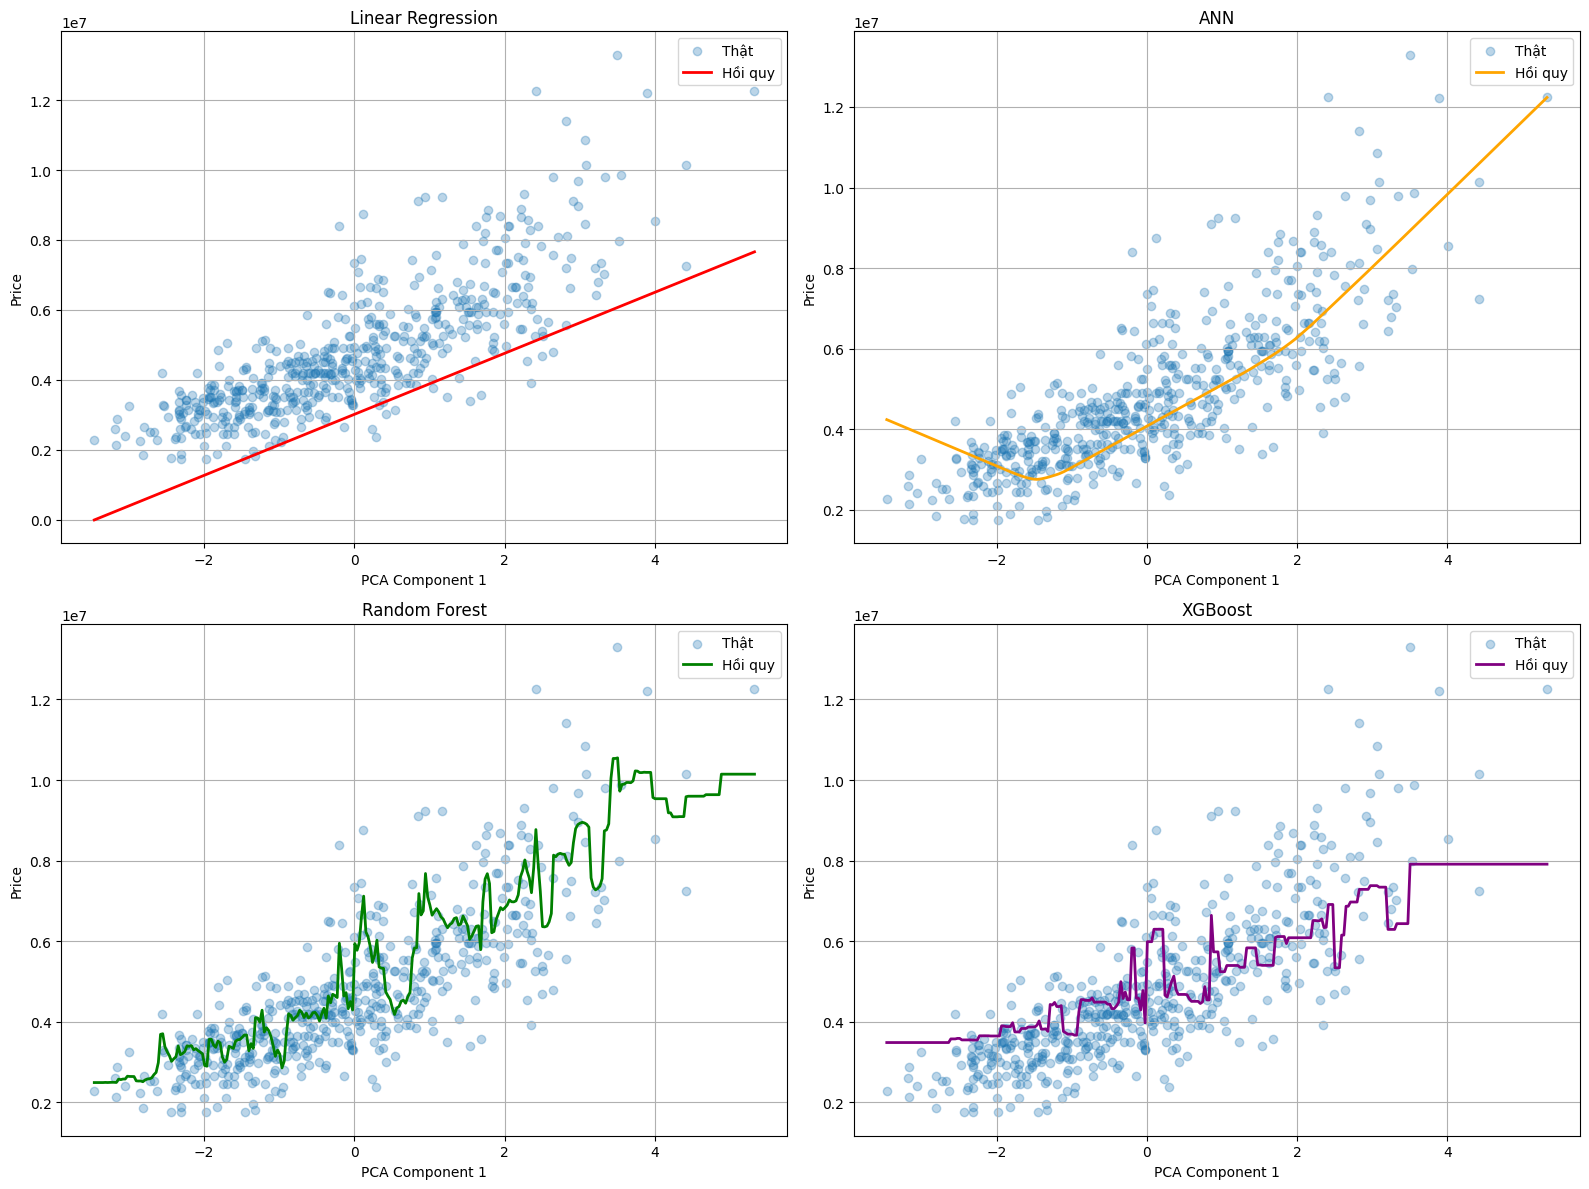

In [19]:
x1_range = np.linspace(X_pca[:, 0].min(), X_pca[:, 0].max(), 300)
x2_mean = np.mean(X_pca[:, 1])
X_line = np.column_stack((x1_range, np.full_like(x1_range, x2_mean)))

# Dự đoán từng model
y_line_lr = model_lr.predict(X_line)
y_line_rf = model_rf.predict(X_line)
y_line_xgb = model_xgb.predict(X_line)
with torch.no_grad():
    X_line_tensor = torch.tensor(X_line, dtype=torch.float32)
    y_line_ann = model_ann(X_line_tensor).numpy().flatten()

# Plot
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

def plot_model(ax, X, y, x_range, y_line, title, color='r'):
    ax.scatter(X[:, 0], y, label='Thật', alpha=0.3)
    ax.plot(x_range, y_line, color=color, label='Hồi quy', linewidth=2)
    ax.set_title(title)
    ax.set_xlabel("PCA Component 1")
    ax.set_ylabel("Price")
    ax.legend()
    ax.grid(True)

plot_model(axs[0, 0], X_pca, y, x1_range, y_line_lr, "Linear Regression", 'red')
plot_model(axs[0, 1], X_pca, y, x1_range, y_line_ann, "ANN", 'orange')
plot_model(axs[1, 0], X_pca, y, x1_range, y_line_rf, "Random Forest", 'green')
plot_model(axs[1, 1], X_pca, y, x1_range, y_line_xgb, "XGBoost", 'purple')

plt.tight_layout()
plt.show()

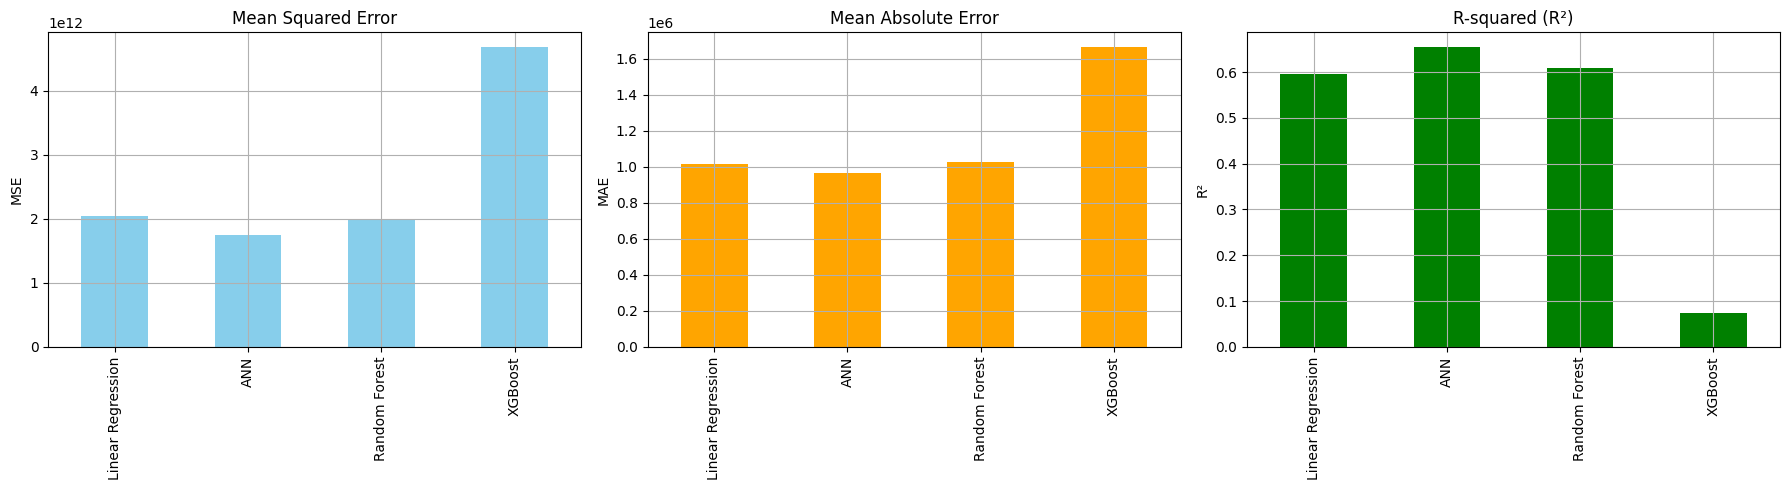

In [20]:
import matplotlib.pyplot as plt

# Đánh giá mô hình với các chỉ số
mse_lr, mae_lr, r2_lr = reg.evaluate(X_test, y_test)
mse_ann, mae_ann, r2_ann = ann_model.evaluate(X_test, y_test)
mse_rf, mae_rf, r2_rf = rf_model.evaluate(X_test, y_test)
mse_xgb, mae_xgb, r2_xgb = xgb_model.evaluate(X_test, y_test)

# Lưu các giá trị vào dictionary để dễ dàng so sánh
metrics = {
    "Linear Regression": [mse_lr, mae_lr, r2_lr],
    "ANN": [mse_ann, mae_ann, r2_ann],
    "Random Forest": [mse_rf, mae_rf, r2_rf],
    "XGBoost": [mse_xgb, mae_xgb, r2_xgb]
}

# Tạo DataFrame cho việc vẽ biểu đồ
metrics_df = pd.DataFrame(metrics, index=["MSE", "MAE", "R²"])

# Vẽ biểu đồ
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Vẽ MSE
metrics_df.loc["MSE"].plot(kind="bar", ax=axs[0], title="Mean Squared Error", color='skyblue')
axs[0].set_ylabel("MSE")
axs[0].grid(True)

# Vẽ MAE
metrics_df.loc["MAE"].plot(kind="bar", ax=axs[1], title="Mean Absolute Error", color='orange')
axs[1].set_ylabel("MAE")
axs[1].grid(True)

# Vẽ R²
metrics_df.loc["R²"].plot(kind="bar", ax=axs[2], title="R-squared (R²)", color='green')
axs[2].set_ylabel("R²")
axs[2].grid(True)

plt.tight_layout()
plt.show()